# Vanilla Generative Model

In [1]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

     |████████████████████████████████| 5.7 MB 5.4 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.0.1
    Uninstalling Pillow-8.0.1:
      Successfully uninstalled Pillow-8.0.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

matplotlib 3.3.2 requires pillow>=6.2.0, but you'll have pillow 4.1.1 which is incompatible.


In [2]:
# import libraries

import os
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

In [4]:
#hyperparameters setting
epoch = 50
batch_size = 512
learning_rate = 0.0002
num_gpus = 1
z_size = 50
middle_size = 200

# Download Data

mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)

# Set Data Loader(input pipeline)

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,drop_last=True)

In [12]:
# build generator and discriminator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(OrderedDict([
                        ('fc1', nn.Linear(z_size, middle_size)),
                        ('bn1', nn.BatchNorm1d(middle_size)),
                        ('act1', nn.ReLU()),
        ]))
        self.layer2 = nn.Sequential(OrderedDict([
                        ('fc2', nn.Linear(middle_size, 784)),
                        #('bn2', nn.BatchNorm1d(784)),
                        ('tanh', nn.Tanh()),
        ]))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, 1, 28, 28)
        
        return out
    
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(OrderedDict([
                        ('fc1', nn.Linear(784, middle_size)),
                        #('bn1', nn.BatchNorm1d(middle_size)),
                        ('act1', nn.LeakyReLU()),
        ]))
        self.layer2 = nn.Sequential(OrderedDict([
                        ('fc2', nn.Linear(middle_size, 1)),
                        ('bn2', nn.BatchNorm1d(1)),
                        ('act2', nn.Sigmoid()),
        ]))
        
    def forward(self, x):
        out = x.view(batch_size, -1)
        out = self.layer1(out)
        out = self.layer2(out)
        
        return out
        
        
device = torch.device("cuda:0" if torch.cuda.is_available() else cpu())
print(device)

generator = Generator().to(device)
discriminator = Discriminator().to(device)

# use multi-GPU for parallel setting
#generator = nn.DataParallel(Generator(), device_ids = [0, 1, 2, 3, 4, 5, 6, 7]).to(device)
#discriminator = nn.DataParallel(Discriminator(), device_ids = [0, 1, 2, 3, 4, 5, 6, 7]).to(device)

loss_func = nn.MSELoss()
gen_optim = torch.optim.Adam(generator.parameters(), lr = learning_rate, betas = (0.5, 0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr = learning_rate, betas = (0.5, 0.999))
one_label = torch.ones(batch_size, 1).to(device)
zero_label = torch.zeros(batch_size, 1).to(device)

# save model
try: 
    generator, discriminator = torch.load('./model/vanilla_gan.pkl')
    print('\n-----model restored-----\n')
except:
    print('\n-----model not restored-----\n')
    pass

try:
    os.mkdir('./model')
except:
    pass

try:
    os.mkdir('./result')
except:
    pass

# train model
for i in range(epoch):
    for j, [image, label] in enumerate(train_loader):
        image = image.to(device)
        # training discriminator
        dis_optim.zero_grad()
        z = init.normal_(torch.Tensor(batch_size, z_size), mean = 0, std = 0.1).to(device)
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)
        
        dis_real = discriminator.forward(image)
        dis_loss = torch.sum(loss_func(dis_fake, zero_label)) + torch.sum(loss_func(dis_real, one_label))
        dis_loss.backward(retain_graph = True)
        dis_optim.step()
        
        # training generator
        gen_optim.zero_grad()
        z = init.normal_(torch.Tensor(batch_size, z_size), mean = 0, std = 0.1).to(device)
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)
        
        gen_loss = torch.sum(loss_func(dis_fake, one_label))  # fake classified as real
        gen_loss.backward()
        gen_optim.step()
        
        if j % 100 == 0:
            print(gen_loss, dis_loss)
            torch.save([generator, discriminator], './model/vanilla_gan.pkl')
            v_utils.save_image(gen_fake.cpu().data[0:25], './result/gen_{}_{}.png'.format(i, j), nrow = 5)
            print('{}th epoch gen_loss : {} dis_loss : {}'.format(i, gen_loss.data, dis_loss.data))

cuda:0

-----model not restored-----

tensor(0.2934, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.5868, device='cuda:0', grad_fn=<AddBackward0>)
0th epoch gen_loss : 0.29344186186790466 dis_loss : 0.5867559909820557


/home/ubuntu18/anaconda3/envs/torch1.5/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu18/anaconda3/envs/torch1.5/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


tensor(0.2858, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4938, device='cuda:0', grad_fn=<AddBackward0>)
0th epoch gen_loss : 0.28578701615333557 dis_loss : 0.4938216507434845
tensor(0.2950, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.5076, device='cuda:0', grad_fn=<AddBackward0>)
1th epoch gen_loss : 0.29498201608657837 dis_loss : 0.5076379776000977
tensor(0.2558, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.5353, device='cuda:0', grad_fn=<AddBackward0>)
1th epoch gen_loss : 0.2558003067970276 dis_loss : 0.5352926850318909
tensor(0.2745, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.5382, device='cuda:0', grad_fn=<AddBackward0>)
2th epoch gen_loss : 0.27451416850090027 dis_loss : 0.5382311940193176
tensor(0.3058, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.5145, device='cuda:0', grad_fn=<AddBackward0>)
2th epoch gen_loss : 0.3057929277420044 dis_loss : 0.5144875645637512
tensor(0.2997, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4935, device='cuda:0',

tensor(0.2856, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4703, device='cuda:0', grad_fn=<AddBackward0>)
23th epoch gen_loss : 0.2856420874595642 dis_loss : 0.47032731771469116
tensor(0.2875, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4693, device='cuda:0', grad_fn=<AddBackward0>)
23th epoch gen_loss : 0.28754186630249023 dis_loss : 0.46925079822540283
tensor(0.2885, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4694, device='cuda:0', grad_fn=<AddBackward0>)
24th epoch gen_loss : 0.2884950637817383 dis_loss : 0.46942809224128723
tensor(0.2900, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4690, device='cuda:0', grad_fn=<AddBackward0>)
24th epoch gen_loss : 0.2900159955024719 dis_loss : 0.46902695298194885
tensor(0.2901, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4671, device='cuda:0', grad_fn=<AddBackward0>)
25th epoch gen_loss : 0.2901315987110138 dis_loss : 0.4670942425727844
tensor(0.2917, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4665, device='c

tensor(0.3244, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4352, device='cuda:0', grad_fn=<AddBackward0>)
45th epoch gen_loss : 0.32436108589172363 dis_loss : 0.43522363901138306
tensor(0.3241, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4375, device='cuda:0', grad_fn=<AddBackward0>)
46th epoch gen_loss : 0.3240585923194885 dis_loss : 0.4375012218952179
tensor(0.3251, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4330, device='cuda:0', grad_fn=<AddBackward0>)
46th epoch gen_loss : 0.32510215044021606 dis_loss : 0.43296635150909424
tensor(0.3254, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4357, device='cuda:0', grad_fn=<AddBackward0>)
47th epoch gen_loss : 0.3254013657569885 dis_loss : 0.43566960096359253
tensor(0.3266, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4330, device='cuda:0', grad_fn=<AddBackward0>)
47th epoch gen_loss : 0.32664114236831665 dis_loss : 0.4330487847328186
tensor(0.3266, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4331, device='

0


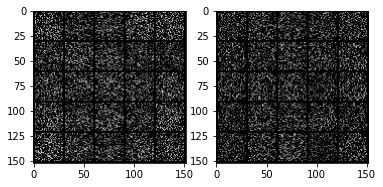

1


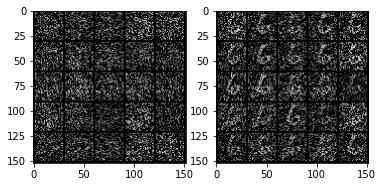

2


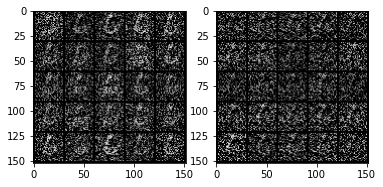

3


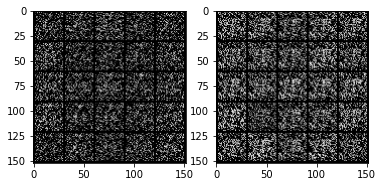

4


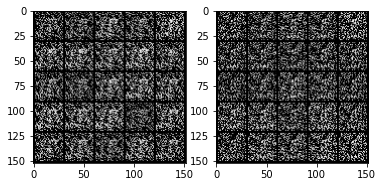

5


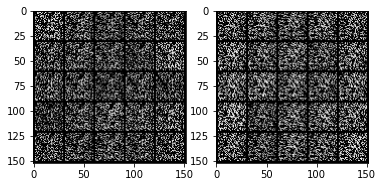

6


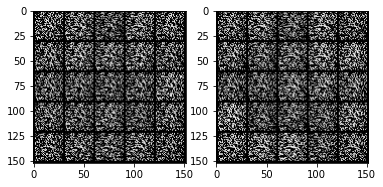

7


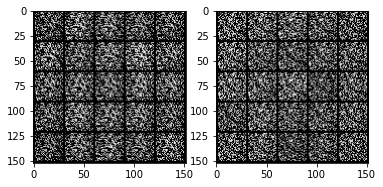

8


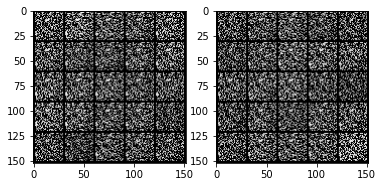

9


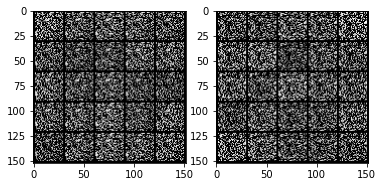

10


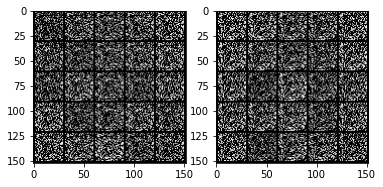

11


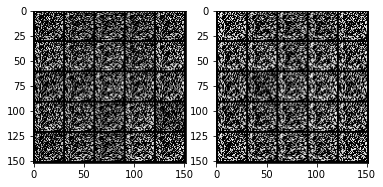

12


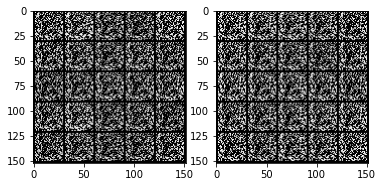

13


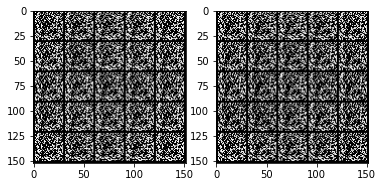

14


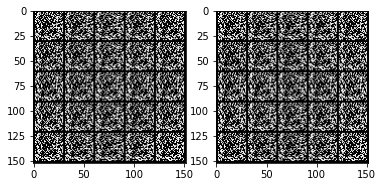

15


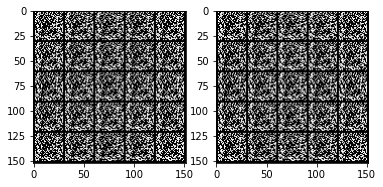

16


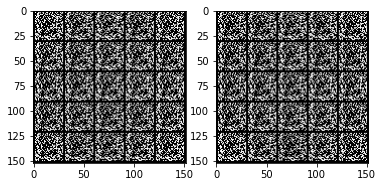

17


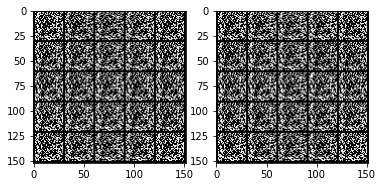

18


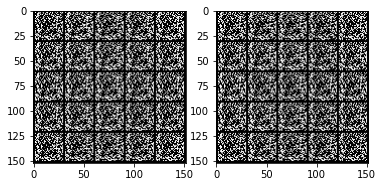

19


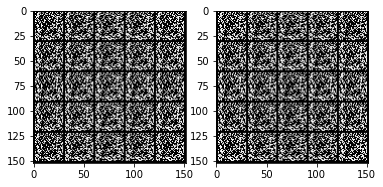

20


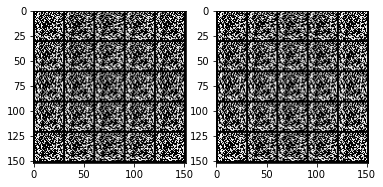

21


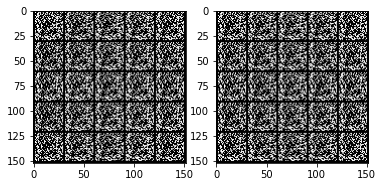

22


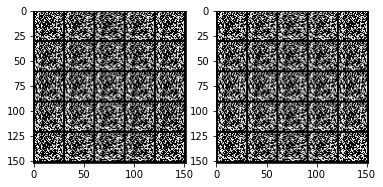

23


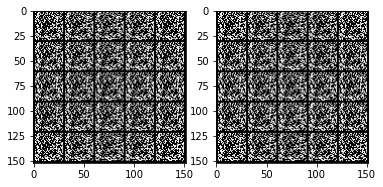

24


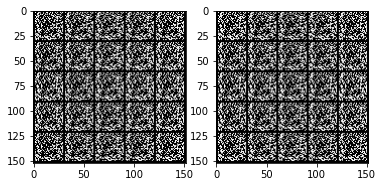

25


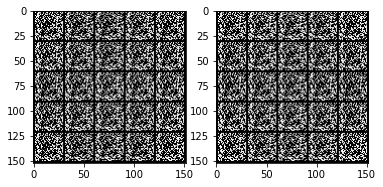

26


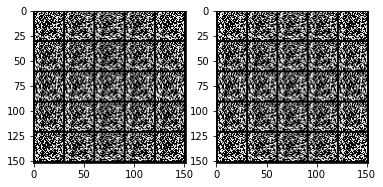

27


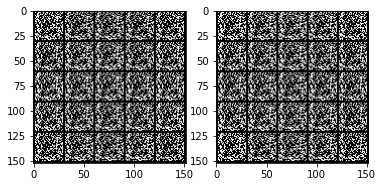

28


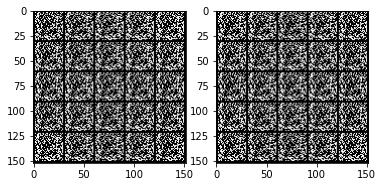

29


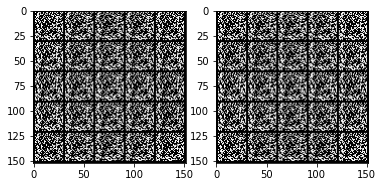

30


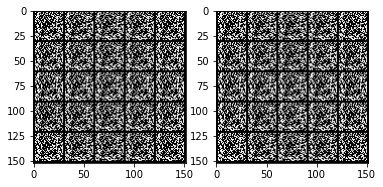

31


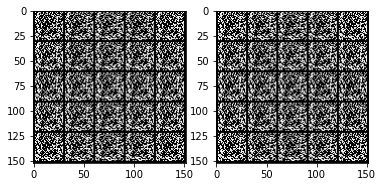

32


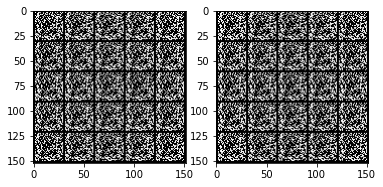

33


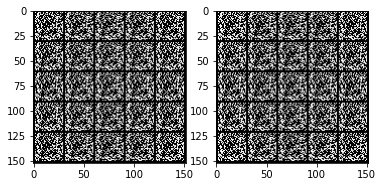

34


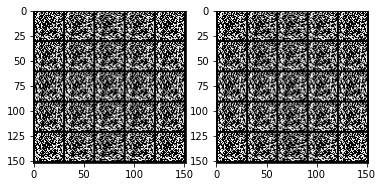

35


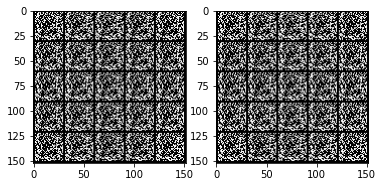

36


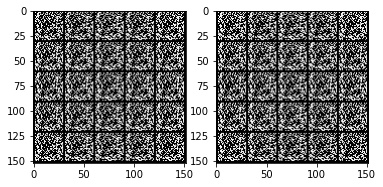

37


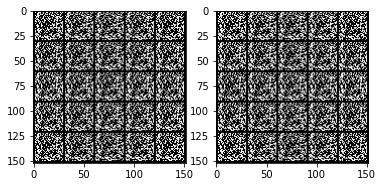

38


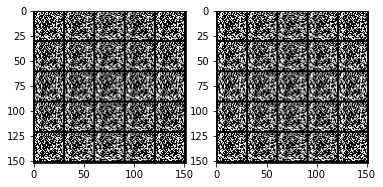

39


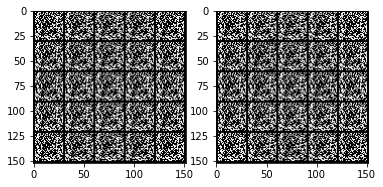

40


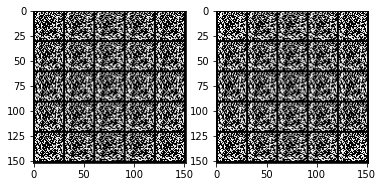

41


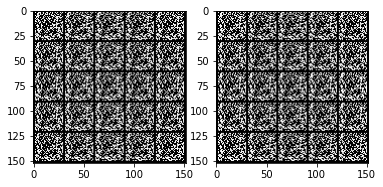

42


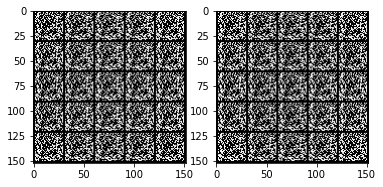

43


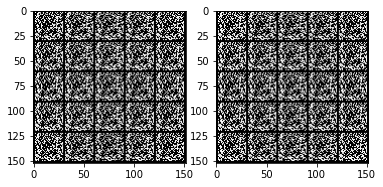

44


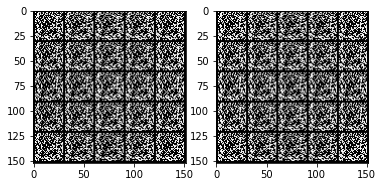

45


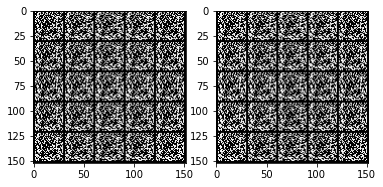

46


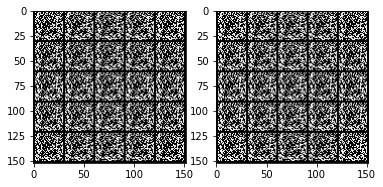

47


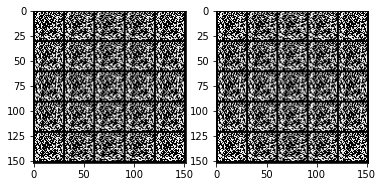

48


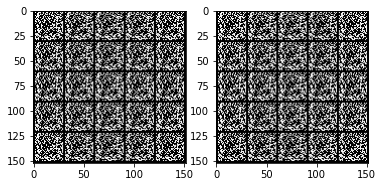

49


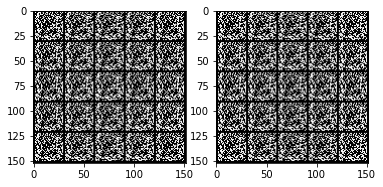

In [16]:
from glob import glob 

for i in range(epoch):
    print(i)
    file_list = glob("./result/gen_{}_*.png".format(i))
    img_per_epoch = len(file_list)
    for idx,j in enumerate(file_list):
        img = plt.imread(j)
        plt.subplot(1,img_per_epoch,idx+1)
        plt.imshow(img)
    plt.show()